In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pickle
from agm_te.dataset import DataSet

In [2]:
areas_list = ['V1', 'RL', 'LM', 'AL', 'PM', 'AM']
areas_index = [0, 1, 2, 3, 4, 5]

# quick plotting function used to visualize the connectivity matrices
def plot_connect_matrix(connect_matrix, title):
    plt.imshow(connect_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xticks(areas_index, areas_list)
    plt.yticks(areas_index, areas_list)
    plt.title(title)
    plt.ylabel('Target area')
    plt.xlabel('Source area')
    plt.show()

### Load Reference Empirical Structural Connectivity Matrix

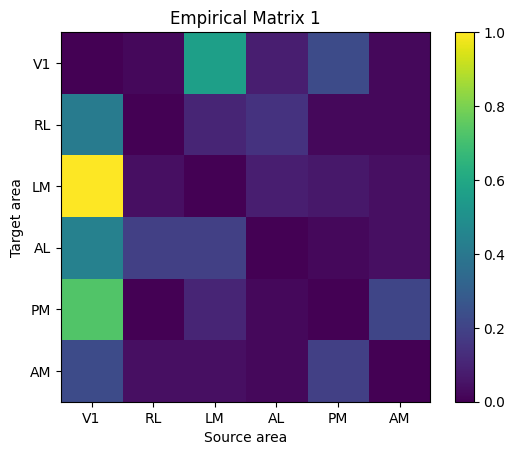

In [3]:
CM1 = pickle.load(open('empirical_data_sourcing/reference_conncectivity_matrix/reference_structural_conn_matrix.pkl', 'rb'))
CM1 = CM1/np.max(CM1)
plot_connect_matrix(CM1, 'Empirical Matrix 1')

### Load Inferred Effective Connectivity Matrices

[[0.   0.28 0.26 0.57 0.22 0.55]
 [1.   0.   0.55 0.3  0.25 0.67]
 [0.9  0.5  0.   0.31 0.47 0.7 ]
 [0.89 0.34 0.49 0.   0.64 0.62]
 [0.87 0.41 0.37 0.4  0.   0.57]
 [0.37 0.37 0.26 0.23 0.41 0.  ]]


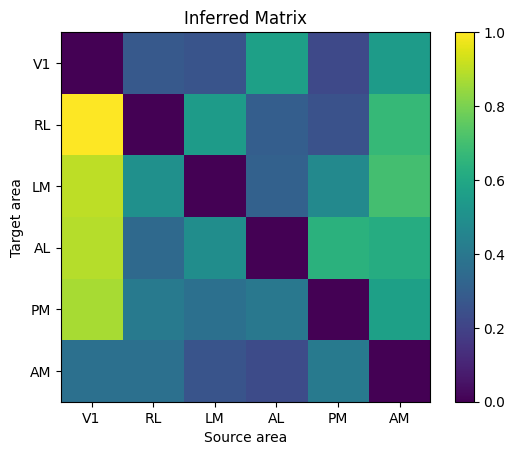

In [9]:
inferred_matrices = pickle.load(open('inferred_EC_matrices.pkl', 'rb'))

### NORMALIZE INFERRED CTE VALUES BY THE DIMENSION OF THE TARGET AREA TO GET EFFECTIVE CONNECTIVITY VALUES ###
valid_sessions = [719161530, 750332458, 750749662, 754312389, 755434585, 756029989, 791319847, 797828357]
areas_list = ['V1', 'RL', 'LM', 'AL', 'PM', 'AM']

inf_matrices = []

for i, valid_session in enumerate(valid_sessions):
    
    allen_datadict = pickle.load(open(f'timeseries_data/session_{valid_session}_100ms.pkl', 'rb'))
    allen_dataset = DataSet(allen_datadict)
    
    temp_mat = inferred_matrices[i]
    for j, area in enumerate(areas_list):
        dim_of_target_area = allen_dataset[area][0].shape[1]
        temp_mat[j] /= dim_of_target_area
    temp_mat *= 10

    inf_matrices.append(temp_mat)

# Average the inferred matrices
inferred_ec_mat = np.mean(inf_matrices, axis=0)
inferred_ec_mat = np.round(inferred_ec_mat/np.max(inferred_ec_mat),2)

print(inferred_ec_mat)
plot_connect_matrix(inferred_ec_mat, 'Inferred Matrix')

### Qualitative Comparison of Connectivity Matrices

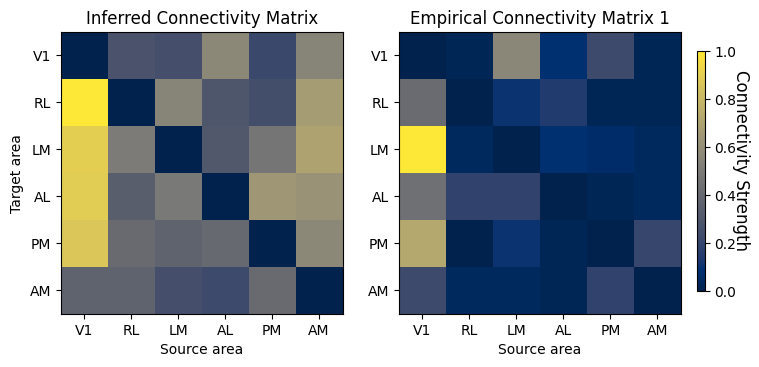

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im = axs[0].imshow(CM1, cmap='cividis', interpolation='nearest')

axs[0].imshow(inferred_ec_mat, cmap='cividis', interpolation='nearest')
axs[0].set_xticks(areas_index, areas_list)
axs[0].set_yticks(areas_index, areas_list)
axs[0].set_title('Inferred Connectivity Matrix')
axs[0].set_xlabel('Source area')
axs[0].set_ylabel('Target area')

axs[1].imshow(CM1, cmap='cividis', interpolation='nearest')
axs[1].set_xticks(areas_index, areas_list)
axs[1].set_yticks(areas_index, areas_list)
axs[1].set_title('Empirical Connectivity Matrix 1')
axs[1].set_xlabel('Source area')


fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.20, 0.01, 0.6])
cbar_ax.set_title('Connectivity Strength', x = 5.5, y=0.15, rotation = -90)
fig.colorbar(im, cax=cbar_ax)
#plt.tight_layout()
#plt.savefig('brain_emp_comparison.pdf')

### Quantitative Comparison of Inferred and Empirical Matrices

In [12]:
s, p = pearsonr(CM1.flatten(), inferred_ec_mat.flatten())
print('Correlation between CM1 and Inferred Matrix: ', s, 'p_val:', p)

Correlation between CM1 and Inferred Matrix:  0.5638118946759916 p_val: 0.0003423633680189375


Bootstrap estimated p-value: 0.99612


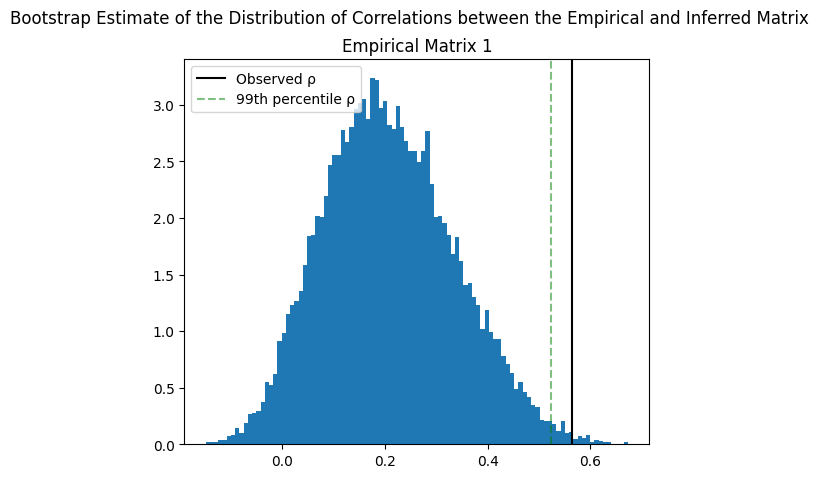

In [14]:
### BOOTSTRAP ESTIMATION OF THE P-VALUE ###
# Construct 25000 bootstrap matrices
valid_values = inferred_ec_mat.flatten()
valid_values = [value for value in valid_values if value != 0]

coeff_list_cm1 = []

for r in range(25000):
    new_mat = np.zeros((6,6))
    for i in range(6):
        for j in range(6):
            if i != j:
                new_mat[i,j] = np.random.choice(valid_values)
    s, p = pearsonr(CM1.flatten(), new_mat.flatten())
    coeff_list_cm1.append(s)

# Measure the percentile of the observed correlation in the bootstrap distribution
s_cm1, p = pearsonr(CM1.flatten(), inferred_ec_mat.flatten())
percentile = sum(coeff_list_cm1 < s_cm1) / len(coeff_list_cm1)
print('Bootstrap estimated p-value:', percentile)

# Plot the distribution of correlations
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
axs.hist(coeff_list_cm1, bins=100, density=True)
axs.axvline(x=s_cm1, color='k', linestyle='-', label='Observed ρ')
axs.axvline(x=np.percentile(coeff_list_cm1, 99), color='g', linestyle='--', alpha=0.5, label='99th percentile ρ')
axs.set_title('Empirical Matrix 1')
axs.legend(loc='upper left')

fig.suptitle('Bootstrap Estimate of the Distribution of Correlations between the Empirical and Inferred Matrix')
plt.show()